## NYC Taxi Trip Duration Feature Engineering & Model Building


## Data Dictionary
It is always a good idea to have the data dictionary handy.

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - duration of the trip in seconds

Here dropoff_datetime and trip_duration are only available for the train set as that represents the target

### Load Libraries
We will load libraries required to build models and validation sets

In [25]:
%matplotlib inline
import numpy as np 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor


### Load Data

In [26]:
df = pd.read_csv('nyc_taxi_final.zip')

## Preprocessing & Feature Extraction

Some of my ideas to create new variables and the reasons are as follows

* Difference between pickup and dropoff latitude - will give an idea about the distance covered which could be predictive
* Difference between pickup and dropoff longitude - same reason as above
* Haversine distance between pickup and dropoff co-ordinates - to capture the actual distance travelled
* Pickup minute - since pickup hour is an important variable, the minute of pickup might well have been predictive
* Pickup day of year - same reason as above





### DateTime Conversion
The datetime features from csv files are read as strings and in order to easily extract features like day of week, month, year etc. we need to convert it into datetime format of python.

In [27]:
# converting strings to datetime features
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

In [28]:
# Log transform the Y values
df_y = np.log1p(df['trip_duration'])

# Add some datetime features
df.loc[:, 'pickup_weekday'] = df['pickup_datetime'].dt.weekday
df.loc[:, 'pickup_hour_weekofyear'] = df['pickup_datetime'].dt.weekofyear
df.loc[:, 'pickup_hour'] = df['pickup_datetime'].dt.hour
df.loc[:, 'pickup_minute'] = df['pickup_datetime'].dt.minute
df.loc[:, 'pickup_dt'] = (df['pickup_datetime'] - df['pickup_datetime'].min()).dt.total_seconds()
df.loc[:, 'pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']


### Distance Features
Distance features must be important and must be included here

#### Eucledian Distance
Let's Calculate the Eucledian distance between pickup and drop off location to get some idea on how far the pickup and dropoff points are since this would definitely impact the trip duration even though we know that cars can't fly

In [29]:

#displacement
y_dist= df['pickup_longitude'] - df['dropoff_longitude']
x_dist = df['pickup_latitude'] - df['dropoff_latitude']

#square distance
df['dist_sq'] = (y_dist ** 2) + (x_dist ** 2)

#distance
df['dist_sqrt'] = df['dist_sq'] ** 0.5



#### Haversine Distance
Let's calculate the distance (km) between pickup and dropoff points. The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes. We will also calculate the approximate angle at which the dropoff location lies wrt the pickup location. pd.DataFrame.apply() would be too slow so the haversine function is rewritten to handle arrays.

<img src="haversine_dist.svg.png" width=200 height=200>

Haversine direction represents the information of angle of the line connecting the dropoff and pickup point over the surface of earth wrt equator.

In [30]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def direction_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


df['haversine_distance'] = haversine_array(df['pickup_latitude'].values, 
                                                     df['pickup_longitude'].values, 
                                                     df['dropoff_latitude'].values, 
                                                     df['dropoff_longitude'].values)


df['direction'] = direction_array(df['pickup_latitude'].values, 
                                          df['pickup_longitude'].values, 
                                          df['dropoff_latitude'].values, 
                                          df['dropoff_longitude'].values)


### Fastest route by road
Sometimes, adding external information can be crucial for improving the model. Here we will use data extracted from The Open Source Routing Machine or OSRM for each trip in our original dataset. OSRM is a C++ implementation of a high-performance routing engine for shortest paths in road networks. This will give us a very good estimate of distances between pickup and dropoff Points

Source: http://project-osrm.org/

In [31]:
fr1 = pd.read_csv('osrm/fastest_routes_train_part_1.zip',
                  usecols=['id', 'total_distance', 'total_travel_time'])
fr2 = pd.read_csv('osrm/fastest_routes_train_part_2.zip',
                  usecols=['id', 'total_distance', 'total_travel_time'])

df_street_info = pd.concat((fr1, fr2))
df = df.merge(df_street_info, how='left', on='id')

df_street_info.head()

,id,total_distance,total_travel_time
0,id2875421,2009.1,164.9
1,id2377394,2513.2,332.0
2,id3504673,1779.4,235.8
3,id2181028,1614.9,140.1
4,id0801584,1393.5,189.4


### Binning
The lattitude and longitude could be a bit noisy and it might be a good idea to bin them and create new features after rounding their values.

In [32]:
### Binned Coordinates ###
df['pickup_latitude_round3'] = np.round(df['pickup_latitude'],3)
df['pickup_longitude_round3'] = np.round(df['pickup_longitude'],3)

df['dropoff_latitude_round3'] = np.round(df['dropoff_latitude'],3)
df['dropoff_longitude_round3'] = np.round(df['dropoff_longitude'],3)

### Other Features

#### One Hot Encoding
Here, Vendor ID can be converted to one hot encoding or frequency encoding since in the raw data it has values 1 and 2 without any inherent order. 

In [33]:
df.vendor_id.value_counts()

2    390481
1    338841
Name: vendor_id, dtype: int64

Now, there is not much difference in the frequencies of both and that might not make for an important feature. so we will just convert it to 0 and 1 by subtracting 1 from it

In [34]:
df['vendor_id'] = df['vendor_id'] - 1

In [35]:
np.sum(pd.isnull(df))

id                          0
vendor_id                   0
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude           0
dropoff_latitude            0
store_and_fwd_flag          0
trip_duration               0
pickup_weekday              0
pickup_hour_weekofyear      0
pickup_hour                 0
pickup_minute               0
pickup_dt                   0
pickup_week_hour            0
dist_sq                     0
dist_sqrt                   0
haversine_distance          0
direction                   0
total_distance              1
total_travel_time           1
pickup_latitude_round3      0
pickup_longitude_round3     0
dropoff_latitude_round3     0
dropoff_longitude_round3    0
dtype: int64

In [36]:
# For a route, the total distance and travel time are not available. Let's impute that with 0
df.fillna(0, inplace = True)

Before we go on to build a model, we must drop the variables that should not be fed as features to the algorithms. We will drop
* id - Uniquely represents a sample in the train set
* pickup_datetime - Since we have extracted the datetime features, there is no need to keep the datetime column
* dropoff_datetime - If this is used to create features, it would be a leakage and we will get perfect model performance. Why? The time gap between dropoff_datetime and pickup_datetime is essentially what we are trying to predict
* trip_duration - This is the target variable so needs to be dropped
* store_and_fwd_flag - This variable is not available before the start of the trip and should not be used for modelling.

In [37]:
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration','store_and_fwd_flag'], axis=1)

## Model Building

Now, before we go on to build the model, let us look at the dataset.

In [38]:
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,...,dist_sq,dist_sqrt,haversine_distance,direction,total_distance,total_travel_time,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,1,1,-73.953918,40.778873,-73.963875,40.771164,0,9,16,40,...,0.000159,0.012592,1.199073,-135.634530,1630.9,172.5,40.779,-73.954,40.771,-73.964
1,0,2,-73.988312,40.731743,-73.994751,40.694931,4,10,23,35,...,0.001397,0.037371,4.129111,-172.445217,5428.7,581.8,40.732,-73.988,40.695,-73.995
2,1,2,-73.997314,40.721458,-73.948029,40.774918,6,7,17,59,...,0.005287,0.072712,7.250753,34.916093,9327.8,748.9,40.721,-73.997,40.775,-73.948
3,1,6,-73.961670,40.759720,-73.956779,40.780628,1,1,9,44,...,0.000461,0.021473,2.361097,10.043567,8022.7,612.2,40.760,-73.962,40.781,-73.957
4,0,1,-74.017120,40.708469,-73.988182,40.740631,2,7,6,42,...,0.001872,0.043264,4.328534,34.280582,5468.7,645.0,40.708,-74.017,40.741,-73.988


We have all numerical data types in our dataset now. Time to delve into model building. A very simple baseline could just be the mean of the values in the train set. Let's check the performance on that.

### Defining Metric

In [39]:
from sklearn.metrics import mean_squared_error
from math import sqrt

### Test Train Split

We have all numbers in our dataset now. Time to delve into model building. But before that, we need to finalise a validation strategy to create the train and test sets. Here, we will do a random split and keep one third of the data in test set and remaining two third of data in the train set

In [40]:
#Splitting the data into Train and Validation set
from sklearn.model_selection import train_test_split 
xtrain, xtest, ytrain, ytest = train_test_split(df,df_y,test_size=1/3, random_state=0)

### Mean Prediction
Before we go on to try any machine learning model, let us look at the performance of a basic model that just says the mean of trip duration in the train set is the prediction for all the trips in the test set.

In [41]:
mean_pred = np.repeat(ytrain.mean(),len(ytest))

sqrt(mean_squared_error(ytest, mean_pred))

0.7986672307875027

### Cross validation
Cross Validation is one of the most important concepts in any type of data modelling. It simply says, try to leave a sample on which you do not train the model and test the model on this sample before finalizing the model.

we divide the entire population into k equal samples. Now we train models on k-1 samples and validate on 1 sample. Then, at the second iteration we train the model with a different sample held as validation. 

In k iterations, we have basically built model on each sample and held each of them as validation. This is a way to reduce the selection bias and reduce the variance in prediction power.

In [42]:
def cv_score(ml_model, rstate = 11,cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    kf = KFold(n_splits=5,random_state=rstate,shuffle=True)
    for train_index,test_index in kf.split(df1,df_y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[train_index],df1.loc[test_index]
        ytr,yvl = df_y[train_index],df_y[test_index]

        model = ml_model
        model.fit(xtr, ytr)
        train_val = model.predict(xtr)
        pred_val = model.predict(xvl)
        rmse_score_train = sqrt(mean_squared_error(ytr, train_val))
        rmse_score = sqrt(mean_squared_error(yvl, pred_val))
        sufix = ""
        msg = ""
        #msg += "Train RMSE: {:.5f} ".format(rmse_score_train)
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        print("{}".format(msg))
        # Save scores
        cv_scores.append(rmse_score)
        i+=1
    return cv_scores

### Linear Regression
Lets begin by using the simplest regression algorithm Linear regression to check the performance.

In [43]:
linreg_scores = cv_score(LinearRegression())


1 of kfold 5
Valid RMSE: 0.54881

2 of kfold 5
Valid RMSE: 0.54975

3 of kfold 5
Valid RMSE: 0.54520

4 of kfold 5
Valid RMSE: 0.56114

5 of kfold 5
Valid RMSE: 0.54677


We can already see that the performance of even linear regression has improved a lot. 

### Decision Tree

In [44]:
dtree_scores = cv_score(DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25))


1 of kfold 5
Valid RMSE: 0.42677

2 of kfold 5
Valid RMSE: 0.42935

3 of kfold 5
Valid RMSE: 0.41977

4 of kfold 5
Valid RMSE: 0.42661

5 of kfold 5
Valid RMSE: 0.42153


In [45]:
results_df = pd.DataFrame({'linear_regression':linreg_scores, 'dtree': dtree_scores})

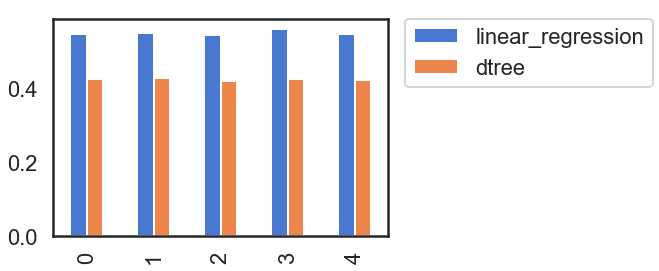

In [46]:
results_df.plot(y=["linear_regression", "dtree"], kind="bar", legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

That's a lot of improvement. The reason for this could be the non linear relationship between the trip duration values and the location coordinates of pickup and dropoff points.

### Decision Tree Visualization

In [47]:
from sklearn import tree

In [48]:
dtree = DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25)
dtree.fit(xtrain, ytrain)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=25,
           min_samples_split=25, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [49]:
decision_tree = tree.export_graphviz(dtree,out_file='tree.dot',feature_names=xtrain.columns,max_depth=2,filled=True)
!dot -Tpng tree.dot -o tree.png

Now, let us view the decision tree till depth 2 and find out the features at the root and the first node.

<img src="tree.png" width=500 height=500>

As is clear from the above decision tree the extra features added are adding a lot of value to our decision tree learning indicating that the additional features carry good value and are very important to the model.